In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # data visualization

# Import PyTorch for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler # preprocessing functions
from sklearn.metrics import mean_absolute_error, mean_squared_error # evaluation metrics
from sklearn.linear_model import LinearRegression # linear regression model

from itertools import product # Import itertools for generating combinations
import heapq # Import heapq for getting top elements from a list

## **Data**

In [2]:
# different file adresses for 3 different index data, only one them should be active
file_address = '/Users/amaanrai/Desktop/DS340w/TechnicalAnalysisStrategyOptimization/ibex.csv'
# file_address = 'data/gdaxi.csv'
# file_address = 'data/dji.csv'

# extracting name of the index from file_address
index_name = file_address.split('/')[-1].split('.')[0].upper()

# Read the CSV file into a DataFrame
df = pd.read_csv(file_address)

# Convert the 'date' column to datetime if it's not already in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'date' column as the index
df.set_index('Date', inplace=True)

# Drop 'Volume' and 'Adj Close' columns
df = df.drop(['Volume', 'Adj Close'], axis=1)

/var/folders/td/dz_wwxjj7sq2s6rq_ydp1t3h0000gn/T/ipykernel_14139/2091087392.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


In [3]:
df

,Open,High,Low,Close
Date,,,,
2011-01-03,9899.400391,9993.599609,9850.500000,9888.299805
2011-01-04,9895.500000,9974.200195,9799.400391,9888.400391
2011-01-05,9877.500000,9882.400391,9599.299805,9801.400391
2011-01-06,9803.200195,9832.599609,9678.400391,9702.700195
2011-01-07,9682.400391,9699.400391,9497.799805,9560.700195
...,...,...,...,...
2019-12-23,9650.200195,9670.900391,9639.000000,9659.599609
2019-12-24,9632.099609,9661.799805,9607.799805,9661.799805
2019-12-27,9673.000000,9700.500000,9657.500000,9700.500000


In [4]:
# Define the split date
split_date = pd.to_datetime('2019-01-01')

# Split the data into train and test sets
train_data = df[df.index < split_date]
test_data = df[df.index >= split_date]

In [5]:
def split_data_x(df, time_window):
    """
    Split a DataFrame into input sequences of a specified time window.
    this function is for x
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        time_window (int): The length of each input sequence.

    Returns:
        np.ndarray: Numpy array of input sequences.

    """
    data_raw = np.array(df)  # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - time_window):
        data.append(data_raw[index: index + time_window].reshape(-1))

    out = np.array(data)
    
    return out

In [6]:
def split_data_y(df, time_window):
    """
    Split a DataFrame into input sequences of a specified time window.
    this function is for x
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        time_window (int): The length of each input sequence.

    Returns:
        np.ndarray: Numpy array of input sequences.

    """
    df = df['Close'] # only need the close price as y
    data_raw = np.array(df)  # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - time_window):
        data.append(data_raw[index + time_window])

    out = np.array(data)
    out = np.expand_dims(out, axis=1)

    return out

# **Strategies**

In [7]:
def calculate_profit_factor(strategy):
    """
    Calculate the profit factor of a trading strategy.

    Args:
        strategy (pd.Series): A pandas Series representing the strategy's trade outcomes.

    Returns:
        float: The profit factor of the strategy.
    """
    positive_trades = strategy.loc[strategy > 0].sum() # Calculate the sum of positive trades
    negative_trades = strategy.loc[strategy < 0].sum() # Calculate the sum of negative trades
    profit_factor = abs(positive_trades / negative_trades) # Calculate the profit factor
    return profit_factor

In [8]:
def calculate_metrics(df):
    # Calculate number of trades
    num_trades = df['Trades'].sum()
    
    # Calculate net profit of the trades
    net_profit = df['PriceStrategy'].sum()
    
    # Calculate profit factor
    profit_factor = calculate_profit_factor(df['Strategy'])
    
    # Calculate average net of each trade
    avg_net_trade = net_profit / num_trades
    
    # Calculate maximum drawdown (price)
    max_drawdown = (df['CPriceStrategy'] - df['CPriceStrategy'].cummax()).min()
    
    # Create a DataFrame to store the metrics
    metrics_df = pd.DataFrame({
        'Number of Trades': [num_trades],
        'Net Profit': [net_profit],
        'Profit Factor': [profit_factor],
        'Average Net per Trade': [avg_net_trade],
        'Maximum Drawdown': [max_drawdown],
    }, index=['Strategy'])
    
    return metrics_df

## **TEMA**

In [9]:
def ema(df, period):
    """
    Calculate the Exponential Moving Average (EMA) of a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        period (int): The number of periods to consider for the EMA calculation.

    Returns:
        pd.DataFrame: The DataFrame with EMA values.

    """
    return df.ewm(span = period, min_periods = period).mean() 

In [10]:
def df_change(df, symbol):
    """
    Create a DataFrame with a single column representing the change in closing prices.

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the change in closing prices.

    Returns:
        pd.DataFrame: A DataFrame with a single column representing the change in closing prices.

    """
    temp = pd.DataFrame(df['Close']) # Create a temporary DataFrame with 'Close' column
    temp = temp.rename({'Close': symbol}, axis=1) # Rename the 'Close' column to the specified symbol
    return temp

In [14]:
def tema_strategy(df, symbol, short_period, mid_period, long_period):
    """
    Implement a trading strategy using TEMA (Triple Exponential Moving Average).

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the price data.
        short_period (int): The period for short-term EMA calculation.
        mid_period (int): The period for mid-term EMA calculation.
        long_period (int): The period for long-term EMA calculation.

    Returns:
        pd.DataFrame: A DataFrame containing the trading strategy signals and performance metrics.

    """
    df = df_change(df, symbol) # Calculate the change in closing prices
    temp = df.copy() # Create a copy of the DataFrame
    
    # Calculate the EMA values for short, mid, and long periods
    temp['ShortEMA'] = ema(df, short_period)
    temp['MidEMA'] = ema(df, mid_period)
    temp['LongEMA'] = ema(df, long_period)
    
    # Determine the position based on EMA crossovers
    temp['Position'] = np.where((temp['ShortEMA'] > temp['MidEMA']) & (temp['ShortEMA'] > temp['LongEMA']), 1,
                                np.where((temp['ShortEMA'] < temp['MidEMA']) & (temp['ShortEMA'] < temp['LongEMA']), -1, 0))
    
    # Calculate log returns and strategy based on log returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp.Position.shift(1) * temp['LogReturns']
    
    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']
    
    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)
    
    # Calculate cumulative log returns, cumulative strategy performance, cumulative price, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()
    
    return temp

In [15]:
def optimize_tema_parameters(df, symbol, short_range, mid_range, long_range):
    """
    Optimize TEMA (Triple Exponential Moving Average) parameters by finding top combinations based on CStrategy.

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the price data.
        short_range (list): A list of short-term EMA period values to consider.
        mid_range (list): A list of mid-term EMA period values to consider.
        long_range (list): A list of long-term EMA period values to consider.

    Returns:
        list: A list of best parameter combinations.
        list: A list of corresponding CStrategy values.

    """
    top_combinations = []
    
    # Iterate over all combinations of short, mid, and long periods
    for short_period, mid_period, long_period in product(short_range, mid_range, long_range):
        if short_period < mid_period < long_period:
            
            # Calculate TEMA strategy performance for the combination of periods
            result = tema_strategy(df, symbol, short_period, mid_period, long_period)
            c_strategy = result['CStrategy'].iloc[-1]
            
            # Use a heap to maintain the top 5 combinations based on CStrategy
            if len(top_combinations) < 5:
                heapq.heappush(top_combinations, (c_strategy, (short_period, mid_period, long_period)))
            else:
                heapq.heappushpop(top_combinations, (c_strategy, (short_period, mid_period, long_period)))
    
    # Get the top 5 combinations with highest CStrategy values
    top_combinations = sorted(top_combinations, reverse=True)
    best_combinations = [combo[1] for combo in top_combinations]
    best_c_strategy = [combo[0] for combo in top_combinations]
    
    return best_combinations, best_c_strategy

In [16]:
# Define the parameter ranges
short_range = range(2, 25)
mid_range = range(5, 41)
long_range = range(8, 81)

# test parameters
# short_range = range(2, 5)
# mid_range = range(5, 7)
# long_range = range(8, 12)

# Run the optimization
best_combinations, best_c_strategy = optimize_tema_parameters(train_data, index_name, short_range, mid_range, long_range)
best_tema_params = best_combinations[0]

# Print the results
print("Best Combinations:")
for i, combination in enumerate(best_combinations):
    print(f"Combination {i+1}: {combination}")
print("Best CStrategy:", best_c_strategy)

Best Combinations:
Combination 1: (2, 5, 8)
Combination 2: (2, 6, 8)
Combination 3: (2, 5, 9)
Combination 4: (2, 6, 9)
Combination 5: (2, 5, 27)
Best CStrategy: [0.9723223684498817, 0.9476243821596281, 0.9244638200633455, 0.9009814900310122, 0.8826728767784987]


In [17]:
print(f"Printing five of the best parameters combinations:\n")

for i, combination in enumerate(best_combinations):
    short_period, mid_period, long_period = combination
    
    # Run the strategy with the current combination
    strategy_result = tema_strategy(test_data, index_name, short_period, mid_period, long_period)
    
    # Calculate the profit factor
    pf_factor = calculate_profit_factor(strategy_result['Strategy'])
    
    # Print the result
    print(f"Combination {i+1}: {combination}")
    print("Profit Factor:", pf_factor)
    print()

Printing five of the best parameters combinations:

Combination 1: (2, 5, 8)
Profit Factor: 0.8619537070112154

Combination 2: (2, 6, 8)
Profit Factor: 0.8542822786061753

Combination 3: (2, 5, 9)
Profit Factor: 0.8686855278170101

Combination 4: (2, 6, 9)
Profit Factor: 0.8606066926483831

Combination 5: (2, 5, 27)
Profit Factor: 0.8801314419028086



In [18]:
tema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2])

,IBEX,ShortEMA,MidEMA,LongEMA,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,
2019-01-02,8550.000000,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.000000,NaN
2019-01-03,8523.299805,8529.974854,NaN,NaN,0,-0.003128,-0.000000,-26.700195,-0.000000,0.0,0.996877,1.000000,-26.700195,0.000000
2019-01-04,8737.799805,8673.853666,NaN,NaN,0,0.024855,0.000000,214.500000,0.000000,0.0,1.021965,1.000000,187.799805,0.000000
2019-01-07,8776.299805,8743.004810,NaN,NaN,0,0.004396,0.000000,38.500000,0.000000,0.0,1.026468,1.000000,226.299805,0.000000
2019-01-08,8847.299805,8812.822121,8751.049583,NaN,0,0.008057,0.000000,71.000000,0.000000,0.0,1.034772,1.000000,297.299805,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,9659.599609,9658.567121,9632.179934,9593.365904,1,-0.001645,-0.001645,-15.900391,-15.900391,0.0,1.129778,0.908978,1109.599609,-868.801756
2019-12-24,9661.799805,9660.722244,9642.053224,9608.573438,1,0.000228,0.000228,2.200196,2.200196,0.0,1.130035,0.909185,1111.799805,-866.601560
2019-12-27,9700.500000,9687.240748,9661.535483,9629.001563,1,0.003997,0.003997,38.700195,38.700195,0.0,1.134561,0.912827,1150.500000,-827.901365


In [19]:
calculate_metrics(tema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,59.0,-915.801756,0.861954,-15.522064,-1515.402342


## **MACD**

In [20]:
def macd_strategy(df, symbol, short_period, long_period, signal_period):
    """
    Implement a trading strategy using MACD (Moving Average Convergence Divergence).

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the price data.
        short_period (int): The period for the short-term EMA calculation.
        long_period (int): The period for the long-term EMA calculation.
        signal_period (int): The period for the signal line calculation.

    Returns:
        pd.DataFrame: A DataFrame containing the trading strategy signals and performance metrics.

    """
    
    df = df_change(df, symbol) # Calculate the change in closing prices
    temp = df.copy() # Create a copy of the DataFrame
    
    # Calculate the short-term and long-term EMAs and MACD line
    temp['ShortEMA'] = ema(df, short_period)
    temp['LongEMA'] = ema(df, long_period)
    temp['MACD Line'] = temp['ShortEMA'] - temp['LongEMA']
    
    # Calculate signal line
    temp['Signal Line'] = ema(temp, signal_period)['MACD Line']
    
    # Generate trading signals based on MACD and signal line crossovers
    temp['Position'] = np.where(temp['MACD Line'] > temp['Signal Line'], 1,
                                np.where(temp['MACD Line'] < temp['Signal Line'], -1, 0))
    
    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol]).shift(1)
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']
    
    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']
    
    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)
    
    # Calculate cumulative log returns, cumulative strategy performance, cumulative price, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()
    
    return temp

In [21]:
def optimize_macd_parameters(df, symbol, short_range, long_range, signal_range):
    """
    Optimize MACD (Moving Average Convergence Divergence) parameters by finding top combinations based on CStrategy.

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the price data.
        short_range (list): A list of short-term EMA period values to consider.
        long_range (list): A list of long-term EMA period values to consider.
        signal_range (list): A list of signal line period values to consider.

    Returns:
        list: A list of best parameter combinations.
        list: A list of corresponding CStrategy values.

    """
    top_combinations = []
    
    # Iterate over all combinations of short, long, and signal periods
    for short_period, long_period, signal_period in product(short_range, long_range, signal_range):
        if short_period < long_period:
            
            # Calculate MACD strategy performance for the combination of periods
            result = macd_strategy(df, symbol, short_period, long_period, signal_period)
            c_strategy = result['CStrategy'].iloc[-1]
            
            # Use a heap to maintain the top 5 combinations based on CStrategy
            if len(top_combinations) < 5:
                heapq.heappush(top_combinations, (c_strategy, (short_period, long_period, signal_period)))
            else:
                heapq.heappushpop(top_combinations, (c_strategy, (short_period, long_period, signal_period)))
    
    # Get the top 5 combinations with highest CStrategy values
    top_combinations = sorted(top_combinations, reverse=True)
    best_combinations = [combo[1] for combo in top_combinations]
    best_c_strategy = [combo[0] for combo in top_combinations]
    
    return best_combinations, best_c_strategy

In [22]:
# Define the parameter ranges
short_range = range(2, 10)
long_range = range(5, 35)
signal_range = range(5, 20)

# test parameters
# short_range = range(2, 5)
# long_range = range(5, 7)
# signal_range = range(5, 10)

# Run the optimization
best_combinations, best_c_strategy = optimize_macd_parameters(train_data, index_name, short_range, long_range, signal_range)
best_macd_params = best_combinations[0]

# Print the best combinations and CStrategy values
print("Best Combinations:")
for i, combination in enumerate(best_combinations):
    print(f"Combination {i+1}: {combination}")
print("Best CStrategy:", best_c_strategy)

Best Combinations:
Combination 1: (2, 6, 6)
Combination 2: (2, 5, 7)
Combination 3: (2, 7, 5)
Combination 4: (3, 5, 5)
Combination 5: (4, 12, 11)
Best CStrategy: [2.08263434764099, 2.0741462205391814, 1.9274577411936382, 1.8325203686750533, 1.6359405412049703]


In [23]:
print(f"Printing five of the best parameters combinations:\n")

for i, combination in enumerate(best_combinations):
    short_period, mid_period, long_period = combination
    
    # Run the strategy with the current combination
    strategy_result = macd_strategy(test_data, index_name, short_period, mid_period, long_period)
    
    # Calculate the profit factor
    pf_factor = calculate_profit_factor(strategy_result['Strategy'])
    
    # Print the result
    print(f"Combination {i+1}: {combination}")
    print("Profit Factor:", pf_factor)
    print()

Printing five of the best parameters combinations:

Combination 1: (2, 6, 6)
Profit Factor: 1.0729032873358262

Combination 2: (2, 5, 7)
Profit Factor: 1.0210299477201406

Combination 3: (2, 7, 5)
Profit Factor: 1.0729032873358262

Combination 4: (3, 5, 5)
Profit Factor: 1.1651487888738226

Combination 5: (4, 12, 11)
Profit Factor: 0.8844230815483378



In [24]:
macd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2])

,IBEX,ShortEMA,LongEMA,MACD Line,Signal Line,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,,
2019-01-02,8550.000000,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.000000,NaN
2019-01-03,8523.299805,8529.974854,NaN,NaN,NaN,0,-0.003128,-0.000000,-26.700195,-0.000000,0.0,0.996877,1.000000,-26.700195,0.000000
2019-01-04,8737.799805,8673.853666,NaN,NaN,NaN,0,0.024855,0.000000,214.500000,0.000000,0.0,1.021965,1.000000,187.799805,0.000000
2019-01-07,8776.299805,8743.004810,NaN,NaN,NaN,0,0.004396,0.000000,38.500000,0.000000,0.0,1.026468,1.000000,226.299805,0.000000
2019-01-08,8847.299805,8812.822121,NaN,NaN,NaN,0,0.008057,0.000000,71.000000,0.000000,0.0,1.034772,1.000000,297.299805,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,9659.599609,9658.567121,9619.675337,38.891783,54.920219,-1,-0.001645,0.001645,-15.900391,15.900391,0.0,1.129778,1.040002,1109.599609,384.907228
2019-12-24,9661.799805,9660.722244,9631.710900,29.011344,47.517683,-1,0.000228,-0.000228,2.200196,-2.200196,0.0,1.130035,1.039765,1111.799805,382.707032
2019-12-27,9700.500000,9687.240748,9651.364928,35.875820,44.191436,-1,0.003997,-0.003997,38.700195,-38.700195,0.0,1.134561,1.035617,1150.500000,344.006837


In [25]:
# macd strategy metric outputs
calculate_metrics(macd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,60.0,495.306642,1.072903,8.255111,-772.899416


# **Prediction**

## **Linear Regression**

In [26]:
# setting up the lookback parameter
time_window = 6

In [27]:
# creating x_train, y_train, x_test and y_test data
x_train = split_data_x(train_data, time_window)
y_train = split_data_y(train_data, time_window)
x_test = split_data_x(test_data, time_window)
y_test = split_data_y(test_data, time_window)

In [28]:
# printing shape of x and y data
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2038, 24)
y_train.shape =  (2038, 1)
x_test.shape =  (249, 24)
y_test.shape =  (249, 1)


In [29]:
# Create and train the linear regression model
regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

LinearRegression()

In [30]:
# Make predictions on the test set
y_pred = regression_model.predict(x_test)

In [31]:
# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (MAE):', mae)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', rmse)

# Calculate the symmetric mean absolute percentage error (sMAPE)
smape = np.mean(np.abs((y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred))) * 2000)
print('Symmetric Mean Absolute Percentage Error (sMAPE):', smape)

# Calculate the mean absolute percentage error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 1000
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Absolute Error (MAE): 53.187274322175256
Root Mean Squared Error (RMSE): 69.73528692827722
Symmetric Mean Absolute Percentage Error (sMAPE): 5.806619610864568
Mean Absolute Percentage Error (MAPE): 5.807646604392941


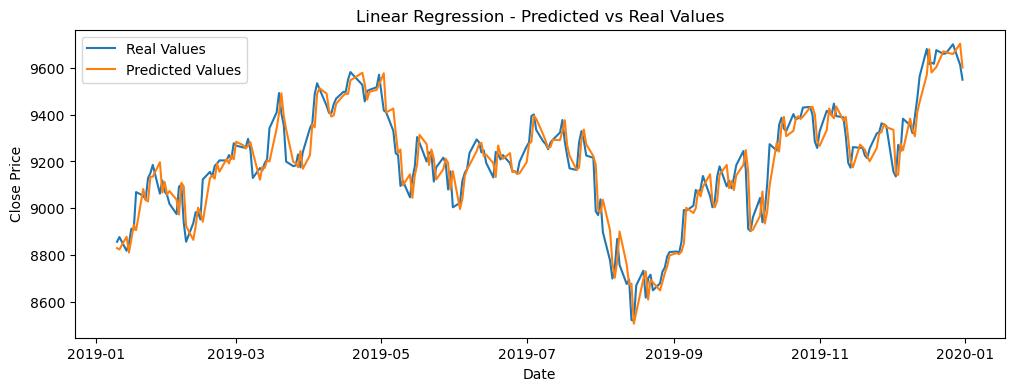

In [32]:
# Plotting the predicted values and real values
plt.figure(figsize=(12, 4))
plt.plot(test_data.iloc[time_window:].index, y_test, label='Real Values')
plt.plot(test_data.iloc[time_window:].index, y_pred, label='Predicted Values')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Linear Regression - Predicted vs Real Values')
plt.legend()
plt.show()

In [33]:
# saving the prediction price for further use
y_pred_lr = pd.DataFrame(y_pred)

# Rename the column
y_pred_lr = y_pred_lr.rename(columns={0: 'Predicted'})

# Add 10 rows with NaN values at the top
y_pred_lr = pd.concat([pd.DataFrame(np.nan,
                                    index=np.arange(time_window),
                                    columns=['Predicted']), y_pred_lr],
                      ignore_index=True)

## **ANN**

In [34]:
# Define the neural network architecture
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ANN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x[:, -1] # Output only the last column (close price)

In [35]:
# Preprocess the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data[['Open', 'Close', 'High', 'Low']])
test_data_scaled = scaler.fit_transform(test_data[['Open', 'Close', 'High', 'Low']])

# Create a new DataFrame with scaled values and original column names
train_data_scaled = pd.DataFrame(train_data_scaled, columns=['Open', 'Close', 'High', 'Low'])
test_data_scaled = pd.DataFrame(test_data_scaled, columns=['Open', 'Close', 'High', 'Low'])

In [36]:
# creating x_train, y_train, x_test and y_test data
x_train = split_data_x(train_data_scaled, time_window)
y_train = split_data_y(train_data_scaled, time_window)
x_test = split_data_x(test_data_scaled, time_window)
y_test = split_data_y(test_data, time_window)

In [37]:
# transforming numpy to tensor
x_train = torch.from_numpy(x_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [38]:
# Set the hyperparameters
hidden_size = 16
lr = 0.00001
num_iterations = 5000

In [39]:
# Define the model
input_size = x_train.shape[1]
output_size = 1
model = ANN(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [40]:
# Train the model
for iteration in range(num_iterations):
    # Forward pass
    output = model(x_train)
    loss = criterion(output, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print the loss
    if (iteration + 1) % 500 == 0:
        print(f'Iteration: {iteration + 1}, Loss: {loss.item()}')

/Users/amaanrai/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2038, 1])) that is different to the input size (torch.Size([2038])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration: 500, Loss: 0.26770976185798645
Iteration: 1000, Loss: 0.1695975661277771
Iteration: 1500, Loss: 0.10956767946481705
Iteration: 2000, Loss: 0.07803276926279068
Iteration: 2500, Loss: 0.064151830971241
Iteration: 3000, Loss: 0.05947793647646904
Iteration: 3500, Loss: 0.05821419879794121
Iteration: 4000, Loss: 0.05769241973757744
Iteration: 4500, Loss: 0.0571899488568306
Iteration: 5000, Loss: 0.05659801512956619


In [41]:
# Compute predictions on the test data
y_pred = model(x_test)

# Reshape the y_pred array to match the shape of the original data
y_pred = y_pred.detach().numpy().reshape(-1, 1)

# Scale the test_data['Close'] using the same scaler used for training data
temp = scaler.fit_transform(test_data[['Close']])

# Inverse transform the scaled y_pred values to get the actual predicted values
y_pred = scaler.inverse_transform(y_pred)

# Convert y_test tensor to a NumPy array
y_test = y_test.detach().numpy()

In [42]:
# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (MAE):', mae)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', rmse)

# Calculate the symmetric mean absolute percentage error (sMAPE)
smape = np.mean(np.abs((y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred))) * 2000)
print('Symmetric Mean Absolute Percentage Error (sMAPE):', smape)

# Calculate the mean absolute percentage error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 1000
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Absolute Error (MAE): 104.498116
Root Mean Squared Error (RMSE): 129.89436
Symmetric Mean Absolute Percentage Error (sMAPE): 11.378409
Mean Absolute Percentage Error (MAPE): 11.362575925886631


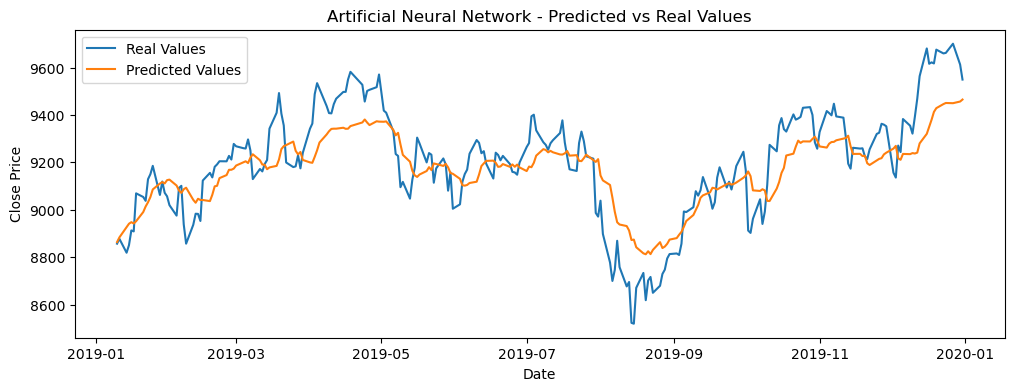

In [43]:
# Plotting the predicted values and real values
plt.figure(figsize=(12, 4))
plt.plot(test_data.iloc[time_window:].index, y_test, label='Real Values')
plt.plot(test_data.iloc[time_window:].index, y_pred, label='Predicted Values')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Artificial Neural Network - Predicted vs Real Values')
plt.legend()
plt.show()

In [44]:
# saving the prediction price for further use
y_pred_ann = pd.DataFrame(y_pred)

# Rename the column
y_pred_ann = y_pred_ann.rename(columns={0: 'Predicted'})

# Add 10 rows with NaN values at the top
y_pred_ann = pd.concat([pd.DataFrame(np.nan,
                                    index=np.arange(time_window),
                                    columns=['Predicted']), y_pred_ann],
                      ignore_index=True)

In [45]:
# LSTM

In [46]:
def htema_strategy(df, symbol, short_period, mid_period, long_period, y_pred):
    """
    Implements a trading strategy based on Hull Triple Exponential Moving Average (HTEMA).

    Args:
        df (pandas.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe that represents the price data.
        short_period (int): Short period for calculating the ShortEMA.
        mid_period (int): Mid period for calculating the MidEMA.
        long_period (int): Long period for calculating the LongEMA.
        y_pred (pandas.DataFrame): Dataframe containing predicted values.

    Returns:
        pandas.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """
    
    df = df_change(df, symbol)
    adjusted_split = len(df) - len(y_pred)  # Find the starting index to trim
    df = df.iloc[adjusted_split:]  # Trim the dataframe to the last 'len(y_pred)' rows
    
    temp = df.copy() # Make a copy of the dataframe
    
    # Calculate EMAs for different periods
    temp['ShortEMA'] = ema(df, short_period)
    temp['MidEMA'] = ema(df, mid_period)
    temp['LongEMA'] = ema(df, long_period)
    
    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where((temp['PredictionPrice'] < temp[symbol].shift(-1)), 1,
                                          np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0))
    
    # Determine strategy position based on EMAs
    temp['StrategyPosition'] = np.where((temp['ShortEMA'] > temp['MidEMA']) & (temp['ShortEMA'] > temp['LongEMA']), 1,
                                np.where((temp['ShortEMA'] < temp['MidEMA']) & (temp['ShortEMA'] < temp['LongEMA']), -1, 0))
    
    # Determine overall position based on strategy position and prediction position
    temp['Position'] = np.where((temp['StrategyPosition'] == 1) | (temp['PredictionPosition'] == 1), 1,
                            np.where((temp['StrategyPosition'] == -1) & (temp['PredictionPosition'] == -1), -1, 0))
    
    # Calculate log returns and strategy based on log returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp.Position.shift(1) * temp['LogReturns']
    
    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']
    
    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)
    
    # Calculate cumulative log returns, cumulative strategy returns, cumulative price change, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()
    
    return temp

In [47]:
def hmacd_strategy(df, symbol, short_period, long_period, signal_period, y_pred):
    """
    Implements a trading strategy based on the Moving Average Convergence Divergence (MACD) indicator.

    Args:
        df (pandas.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe that represents the price data.
        short_period (int): Short period for calculating the short exponential moving average (ShortEMA).
        long_period (int): Long period for calculating the long exponential moving average (LongEMA).
        signal_period (int): Signal period for calculating the signal line.
        y_pred (pandas.DataFrame): Dataframe containing predicted values.

    Returns:
        pandas.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """
    
    df = df_change(df, symbol)
    adjusted_split = len(df) - len(y_pred)  # Find the starting index to trim
    df = df.iloc[adjusted_split:]  # Trim the dataframe to the last 'len(y_pred)' rows
    temp = df.copy() # Make a copy of the dataframe
    
    # Calculate MACD line using short and long EMAs
    temp['ShortEMA'] = ema(df, short_period)
    temp['LongEMA'] = ema(df, long_period)
    temp['MACD Line'] = temp['ShortEMA'] - temp['LongEMA']
    
    # Calculate signal line
    temp['Signal Line'] = ema(temp, signal_period)['MACD Line']
    
    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where((temp['PredictionPrice'] < temp[symbol].shift(-1)), 1,
                                          np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0))
    
    # Determine strategy position based on MACD line and signal line
    temp['StrategyPosition'] = np.where(temp['MACD Line'] > temp['Signal Line'], 1,
                                np.where(temp['MACD Line'] < temp['Signal Line'], -1, 0))
    
    # Generate trading signals based on strategy position and prediction position
    temp['Position'] = np.where((temp['StrategyPosition'] == 1) | (temp['PredictionPosition'] == 1), 1,
                            np.where((temp['StrategyPosition'] == -1) & (temp['PredictionPosition'] == -1), -1, 0))
    
    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol]).shift(1)
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']
    
    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']
    
    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)
    
    # Calculate cumulative log returns, cumulative strategy returns, cumulative price change, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()
    
    return temp

In [48]:
# 1. Data Preparation
def prepare_data_for_lstm(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Assuming you're using the 'Close' prices
data = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

seq_length = 10  # You can adjust this
X, y = prepare_data_for_lstm(data_scaled, seq_length)

# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

# 2. Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 3. Train the model
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

num_epochs = 100
batch_size = 32

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 4. Make predictions
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = scaler.inverse_transform(y_pred.numpy())
    y_test = scaler.inverse_transform(y_test.numpy())
    
# Adjust the split to consider the sequence length
adjusted_split = len(df) - len(y_pred)
test_data = df.iloc[adjusted_split:]
print(f"Adjusted test data length: {len(test_data)}")  # Should print 458

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')

# 5. Integrate with trading strategy
# You can now use the LSTM predictions (y_pred) in your trading strategy
# For example, you could replace the linear regression predictions with these LSTM predictions
y_pred_lstm = pd.DataFrame(y_pred, columns=['Predicted'], index=test_data.index[-len(y_pred):])

# Now you can use y_pred_lstm in your hybrid strategies instead of y_pred_lr
htema_lstm = htema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lstm)
hmacd_lstm = hmacd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_lstm)

# Calculate and compare metrics
print("HTEMA with LSTM:")
print(calculate_metrics(htema_lstm))
print("\nHMACD with LSTM:")
print(calculate_metrics(hmacd_lstm))

Epoch [10/100], Loss: 0.0005
Epoch [20/100], Loss: 0.0022
Epoch [30/100], Loss: 0.0006
Epoch [40/100], Loss: 0.0012
Epoch [50/100], Loss: 0.0003
Epoch [60/100], Loss: 0.0008
Epoch [70/100], Loss: 0.0003
Epoch [80/100], Loss: 0.0004
Epoch [90/100], Loss: 0.0003
Epoch [100/100], Loss: 0.0003
Adjusted test data length: 458
MAE: 61.9933, RMSE: 81.2449
HTEMA with LSTM:
          Number of Trades   Net Profit  Profit Factor  Average Net per Trade  \
Strategy              99.0  9453.900391       2.206888              95.493943   

          Maximum Drawdown  
Strategy       -374.600589  

HMACD with LSTM:
          Number of Trades   Net Profit  Profit Factor  Average Net per Trade  \
Strategy             120.0  9711.998038       2.181267              80.933317   

          Maximum Drawdown  
Strategy       -594.498048  


# **Hybrid Strategies**

## **Strategy 1**

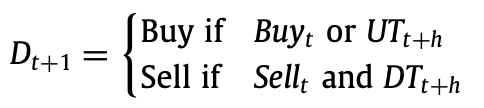

### **hTEMA**

In [49]:
htema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lr)


,IBEX,ShortEMA,MidEMA,LongEMA,PredictionPrice,PredictionPosition,StrategyPosition,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,,,,
2019-01-02,8550.000000,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.000000,NaN
2019-01-03,8523.299805,8529.974854,NaN,NaN,NaN,0,0,0,-0.003128,-0.000000,-26.700195,-0.000000,0.0,0.996877,1.000000,-26.700195,0.000000
2019-01-04,8737.799805,8673.853666,NaN,NaN,NaN,0,0,0,0.024855,0.000000,214.500000,0.000000,0.0,1.021965,1.000000,187.799805,0.000000
2019-01-07,8776.299805,8743.004810,NaN,NaN,NaN,0,0,0,0.004396,0.000000,38.500000,0.000000,0.0,1.026468,1.000000,226.299805,0.000000
2019-01-08,8847.299805,8812.822121,8751.049583,NaN,NaN,0,0,0,0.008057,0.000000,71.000000,0.000000,0.0,1.034772,1.000000,297.299805,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,9659.599609,9658.567121,9632.179934,9593.365904,9671.058798,-1,1,1,-0.001645,-0.001645,-15.900391,-15.900391,0.0,1.129778,1.617677,1109.599609,4367.404299
2019-12-24,9661.799805,9660.722244,9642.053224,9608.573438,9666.421813,1,1,1,0.000228,0.000228,2.200196,2.200196,0.0,1.130035,1.618046,1111.799805,4369.604495
2019-12-27,9700.500000,9687.240748,9661.535483,9629.001563,9658.894083,-1,1,1,0.003997,0.003997,38.700195,38.700195,0.0,1.134561,1.624527,1150.500000,4408.304690


#### **Comparing TEMA and hTEMA**

In [50]:
calculate_metrics(tema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,94.0,264.697265,1.020624,2.815928,-1515.402342


In [51]:
calculate_metrics(htema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,61.0,4320.404299,2.007283,70.8263,-332.399414


### **hMACD**

In [52]:
hmacd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_lr)

,IBEX,ShortEMA,LongEMA,MACD Line,Signal Line,PredictionPrice,PredictionPosition,StrategyPosition,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,,,,,
2019-01-02,8550.000000,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.000000,NaN
2019-01-03,8523.299805,8529.974854,NaN,NaN,NaN,NaN,0,0,0,-0.003128,-0.000000,-26.700195,-0.000000,0.0,0.996877,1.000000,-26.700195,0.000000
2019-01-04,8737.799805,8673.853666,NaN,NaN,NaN,NaN,0,0,0,0.024855,0.000000,214.500000,0.000000,0.0,1.021965,1.000000,187.799805,0.000000
2019-01-07,8776.299805,8743.004810,NaN,NaN,NaN,NaN,0,0,0,0.004396,0.000000,38.500000,0.000000,0.0,1.026468,1.000000,226.299805,0.000000
2019-01-08,8847.299805,8812.822121,NaN,NaN,NaN,NaN,0,0,0,0.008057,0.000000,71.000000,0.000000,0.0,1.034772,1.000000,297.299805,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,9659.599609,9658.567121,9619.675337,38.891783,54.920219,9671.058798,-1,-1,-1,-0.001645,-0.001645,-15.900391,-15.900391,1.0,1.129778,1.753295,1109.599609,5152.807614
2019-12-24,9661.799805,9660.722244,9631.710900,29.011344,47.517683,9666.421813,1,-1,1,0.000228,-0.000228,2.200196,-2.200196,1.0,1.130035,1.752896,1111.799805,5150.607418
2019-12-27,9700.500000,9687.240748,9651.364928,35.875820,44.191436,9658.894083,-1,-1,-1,0.003997,0.003997,38.700195,38.700195,1.0,1.134561,1.759917,1150.500000,5189.307613


#### **Comparing MACD and hMACD**

In [53]:
calculate_metrics(macd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,104.0,2484.204096,1.207246,23.886578,-781.402344


In [54]:
calculate_metrics(hmacd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,71.0,5340.607418,2.334936,75.219823,-594.498048


## **Strategy 2**

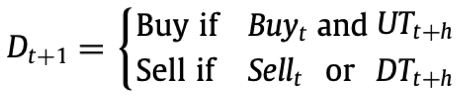

### **hTEMA**

In [55]:
def htema_strategy_2(df, symbol, short_period, mid_period, long_period, y_pred):
    """
    Implements a trading strategy based on Hull Triple Exponential Moving Average (HTEMA).

    Args:
        df (pandas.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe that represents the price data.
        short_period (int): Short period for calculating the ShortEMA.
        mid_period (int): Mid period for calculating the MidEMA.
        long_period (int): Long period for calculating the LongEMA.
        y_pred (pandas.DataFrame): Dataframe containing predicted values.

    Returns:
        pandas.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """
    
    df = df_change(df, symbol)
    adjusted_split = len(df) - len(y_pred)  # Find the starting index to trim
    df = df.iloc[adjusted_split:]  # Trim the dataframe to the last 'len(y_pred)' rows
    
    temp = df.copy() # Make a copy of the dataframe
    
    # Calculate EMAs for different periods
    temp['ShortEMA'] = ema(df, short_period)
    temp['MidEMA'] = ema(df, mid_period)
    temp['LongEMA'] = ema(df, long_period)
    
    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where((temp['PredictionPrice'] < temp[symbol].shift(-1)), 1,
                                          np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0))
    
    # Determine strategy position based on EMAs
    temp['StrategyPosition'] = np.where((temp['ShortEMA'] > temp['MidEMA']) & (temp['ShortEMA'] > temp['LongEMA']), 1,
                                np.where((temp['ShortEMA'] < temp['MidEMA']) & (temp['ShortEMA'] < temp['LongEMA']), -1, 0))
    
    # Determine overall position based on strategy position and prediction position
    temp['Position'] = np.where((temp['StrategyPosition'] == 1) & (temp['PredictionPosition'] == 1), 1,
                            np.where((temp['StrategyPosition'] == -1) | (temp['PredictionPosition'] == -1), -1, 0))
    
    # Calculate log returns and strategy based on log returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp.Position.shift(1) * temp['LogReturns']
    
    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']
    
    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)
    
    # Calculate cumulative log returns, cumulative strategy returns, cumulative price change, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()
    
    return temp

#### **Comparing TEMA, hTEMA1, and hTEMA2**

In [56]:
calculate_metrics(tema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,94.0,264.697265,1.020624,2.815928,-1515.402342


In [63]:
calculate_metrics(htema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,99.0,9453.900391,2.206888,95.493943,-374.600589


In [64]:
calculate_metrics(htema_strategy_2(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,133.0,10135.396466,2.289636,76.205988,-387.200195


### **hMACD**

In [59]:
def hmacd_strategy_2(df, symbol, short_period, long_period, signal_period, y_pred):
    """
    Implements a trading strategy based on the Moving Average Convergence Divergence (MACD) indicator.

    Args:
        df (pandas.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe that represents the price data.
        short_period (int): Short period for calculating the short exponential moving average (ShortEMA).
        long_period (int): Long period for calculating the long exponential moving average (LongEMA).
        signal_period (int): Signal period for calculating the signal line.
        y_pred (pandas.DataFrame): Dataframe containing predicted values.

    Returns:
        pandas.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """
    
    df = df_change(df, symbol)
    adjusted_split = len(df) - len(y_pred)  # Find the starting index to trim
    df = df.iloc[adjusted_split:]  # Trim the dataframe to the last 'len(y_pred)' rows
    temp = df.copy() # Make a copy of the dataframe
    
    # Calculate MACD line using short and long EMAs
    temp['ShortEMA'] = ema(df, short_period)
    temp['LongEMA'] = ema(df, long_period)
    temp['MACD Line'] = temp['ShortEMA'] - temp['LongEMA']
    
    # Calculate signal line
    temp['Signal Line'] = ema(temp, signal_period)['MACD Line']
    
    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where((temp['PredictionPrice'] < temp[symbol].shift(-1)), 1,
                                          np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0))
    
    # Determine strategy position based on MACD line and signal line
    temp['StrategyPosition'] = np.where(temp['MACD Line'] > temp['Signal Line'], 1,
                                np.where(temp['MACD Line'] < temp['Signal Line'], -1, 0))
    
    # Generate trading signals based on strategy position and prediction position
    temp['Position'] = np.where((temp['StrategyPosition'] == 1) & (temp['PredictionPosition'] == 1), 1,
                            np.where((temp['StrategyPosition'] == -1) | (temp['PredictionPosition'] == -1), -1, 0))
    
    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol]).shift(1)
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']
    
    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']
    
    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)
    
    # Calculate cumulative log returns, cumulative strategy returns, cumulative price change, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()
    
    return temp

#### **Comparing MACD, hMACD1, and hMACD2**

In [60]:
calculate_metrics(macd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,104.0,2484.204096,1.207246,23.886578,-781.402344


In [65]:
calculate_metrics(hmacd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,120.0,9711.998038,2.181267,80.933317,-594.498048


In [66]:
calculate_metrics(hmacd_strategy_2(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,113.0,12096.80565,2.693171,107.051377,-340.799804
